In [3]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/trades.db")
df = pd.read_sql_query("SELECT * FROM trades ORDER BY timestamp", conn, parse_dates=["timestamp"])
conn.close()

# Quick peek
df.head()

,id,timestamp,symbol,strategy,side,price,amount,cost,reason
0,1,2025-05-23 18:33:59.098243,SOL/USDT,RsiStrategy,buy,179.82,0.055611,9.999999,None
1,2,2025-05-23 18:53:58.896951,SOL/USDT,RsiStrategy,sell,178.62,0.055611,9.933265,trailing-stop
2,3,2025-05-23 19:08:58.896126,SOL/USDT,RsiStrategy,buy,179.67,0.055658,9.999999,None
3,4,2025-05-23 19:23:58.914072,SOL/USDT,RsiStrategy,sell,179.76,0.055658,10.005008,time-cap
4,5,2025-05-23 20:43:58.869882,SOL/USDT,RsiStrategy,buy,177.51,0.056335,9.999999,None


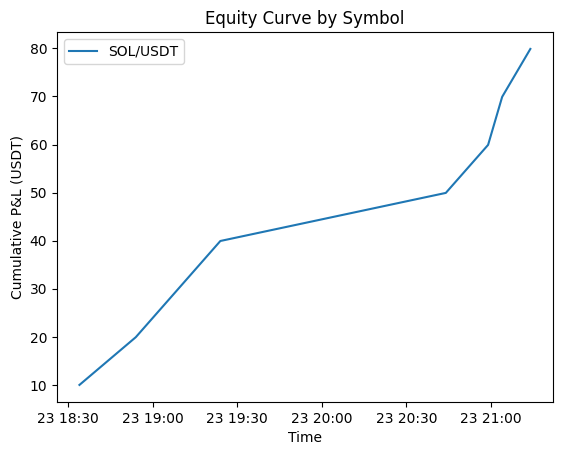

In [4]:
import matplotlib.pyplot as plt

# cumulative P&L by symbol
df["cum_pnl"] = df.groupby("symbol")["cost"].cumsum()

plt.figure()
for sym, grp in df.groupby("symbol"):
    plt.plot(grp["timestamp"], grp["cum_pnl"], label=sym)
plt.legend()
plt.title("Equity Curve by Symbol")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()


In [5]:
import sqlite3
import pandas as pd

# ─── Load live trades from SQLite ─────────────────────────────────────────────
conn = sqlite3.connect("data/trades.db")
df = pd.read_sql_query(
    "SELECT * FROM trades ORDER BY timestamp",
    conn,
    parse_dates=["timestamp"]
)
conn.close()

# ─── Compute P&L summary by symbol & strategy ─────────────────────────────────
summary = df.groupby(["symbol", "strategy"])["cost"] \
            .agg(total_pnl="sum", trades="count") \
            .reset_index()

# Display the result
summary



,symbol,strategy,total_pnl,trades
0,SOL/USDT,RsiStrategy,79.888079,8


In [6]:
# ─── Cell 1: Run Backtest & Load Trades ──────────────────────────────────────
from backtest import run_backtest
from config import FAST_SMA, SLOW_SMA
import pandas as pd

# Run the backtest with your default SMA settings
result = run_backtest(FAST_SMA, SLOW_SMA)

# Build a DataFrame of individual trades
df_trades = pd.DataFrame(result['trades'])
df_trades.head()

Backtest run at 2025-05-23T22:45:12.750410 UTC for FAST=10, SLOW=100
Total trades: 6, Total P&L: -9.15 USDT


,entry_index,exit_index,entry_price,exit_price,pnl
0,112,144,179.00,178.57,-0.966355
1,146,174,179.45,178.20,-1.786476
2,211,213,178.53,178.13,-0.934990
3,220,300,179.68,180.89,0.669146
4,320,368,182.69,179.29,-3.942972


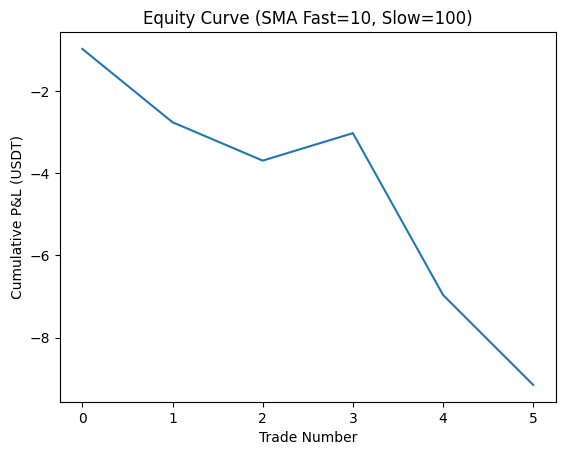

In [7]:
# ─── Cell 2: Equity Curve ───────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Cumulative P&L over each trade
equity = df_trades['pnl'].cumsum()

plt.figure()
plt.plot(equity)
plt.title(f"Equity Curve (SMA Fast={FAST_SMA}, Slow={SLOW_SMA})")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()

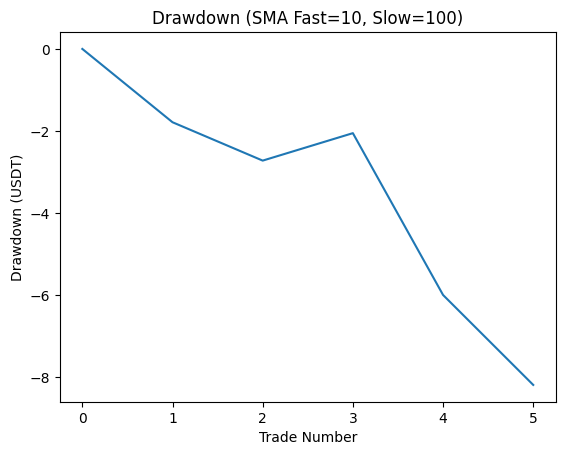

In [8]:
# ─── Cell 3: Drawdown Curve ────────────────────────────────────────────────
# Drawdown = equity − running max equity
high_water = equity.cummax()
drawdown = equity - high_water

plt.figure()
plt.plot(drawdown)
plt.title(f"Drawdown (SMA Fast={FAST_SMA}, Slow={SLOW_SMA})")
plt.xlabel("Trade Number")
plt.ylabel("Drawdown (USDT)")
plt.show()

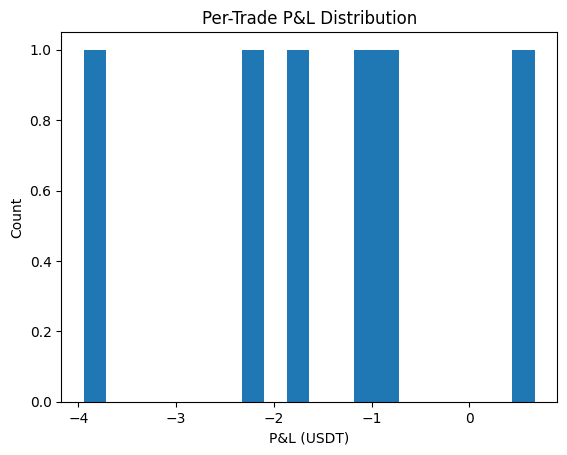

In [9]:
# ─── Cell 4: Per-Trade P&L Distribution ────────────────────────────────────
plt.figure()
plt.hist(df_trades['pnl'], bins=20)
plt.title("Per-Trade P&L Distribution")
plt.xlabel("P&L (USDT)")
plt.ylabel("Count")
plt.show()

In [1]:
# ─── Cell: MACD Backtest & Load Trades ────────────────────────────────────────
from backtest_macd import run_backtest_macd
import pandas as pd

# Run the MACD backtest and build a DataFrame
res_macd = run_backtest_macd()
df_macd = pd.DataFrame(res_macd["trades"])
df_macd.head()


MACD Backtest run at 2025-05-23T23:00:45.318519 UTC
MACD: Total trades=17, Total P&L=-4.37 USDT


,entry_index,exit_index,entry_price,exit_price,pnl
0,77,92,178.47,177.53,-1.474000
1,96,97,178.27,177.55,-1.253730
2,99,100,178.17,177.60,-1.103655
3,101,126,178.53,179.02,-0.046325
4,129,131,179.75,179.19,-1.098410


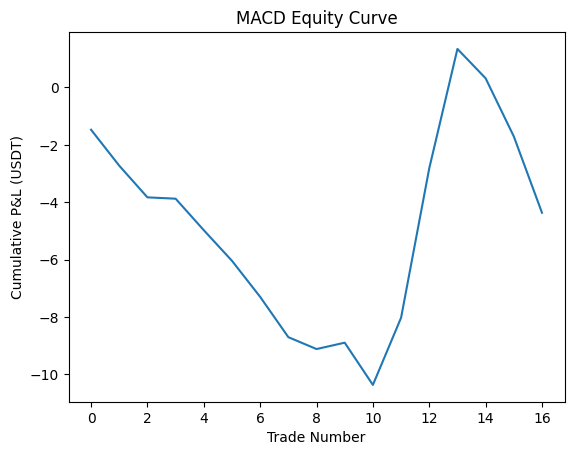

In [2]:
# ─── Cell: MACD Equity Curve ─────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Cumulative P&L over each MACD trade
equity_macd = df_macd["pnl"].cumsum()

plt.figure()
plt.plot(equity_macd)
plt.title("MACD Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()


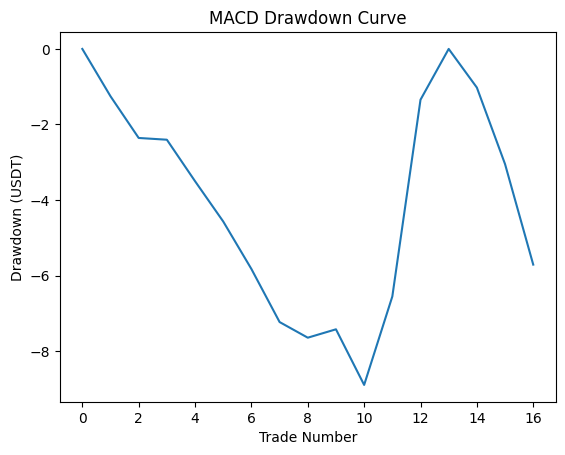

In [3]:
# ─── Cell: MACD Drawdown Curve ──────────────────────────────────────────────
# Drawdown = equity − running max equity
high_water_macd = equity_macd.cummax()
drawdown_macd = equity_macd - high_water_macd

plt.figure()
plt.plot(drawdown_macd)
plt.title("MACD Drawdown Curve")
plt.xlabel("Trade Number")
plt.ylabel("Drawdown (USDT)")
plt.show()


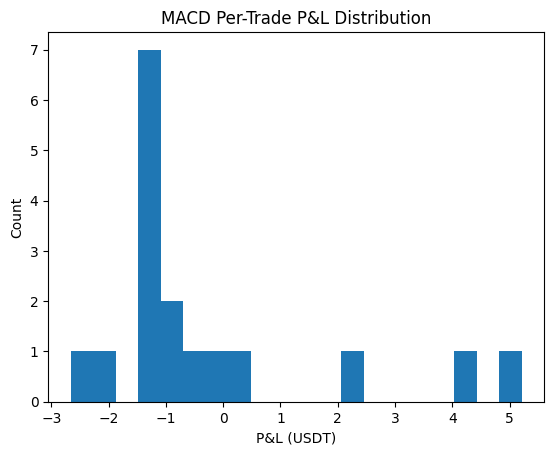

In [4]:
# ─── Cell: MACD Per-Trade P&L Distribution ──────────────────────────────────
plt.figure()
plt.hist(df_macd["pnl"], bins=20)
plt.title("MACD Per-Trade P&L Distribution")
plt.xlabel("P&L (USDT)")
plt.ylabel("Count")
plt.show()


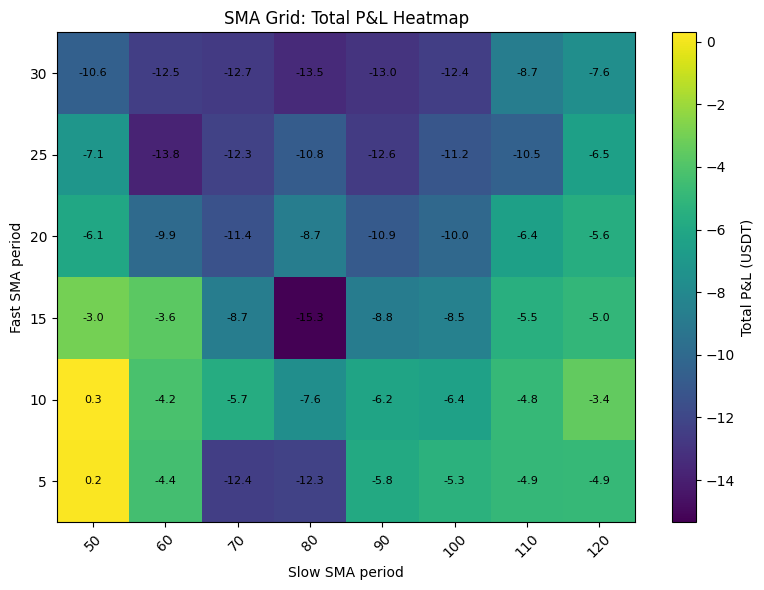

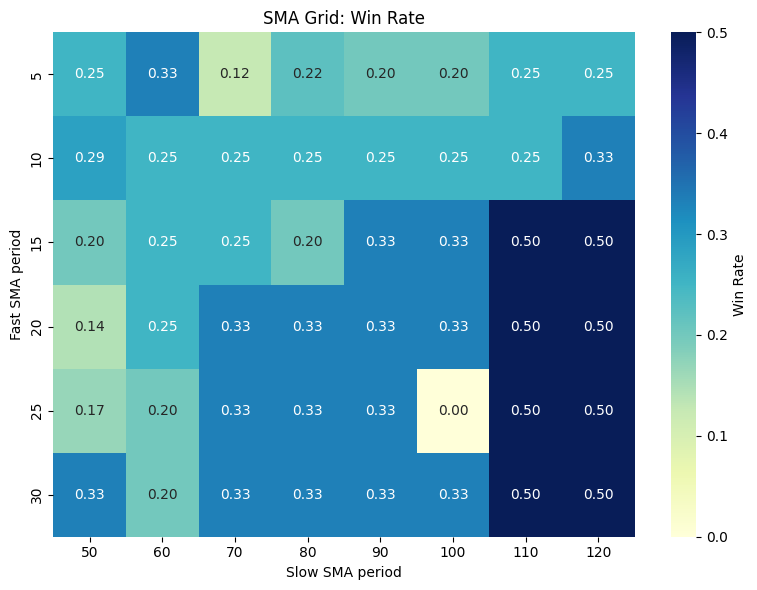

interactive(children=(IntRangeSlider(value=(5, 30), continuous_update=False, description='Fast SMA:', max=50, …

<function __main__.interactive_sweep(fast_range, slow_range)>

In [1]:
# ─── Combined Interactive SMA Grid (P&L + Win Rate) ────────────────────────────
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from grid_backtest import grid_search, grid_search_with_winrate
from config import FEE_PCT, SLIPPAGE_PCT

def plot_sma_heatmap(fast_list, slow_list):
    """Displays the annotated P&L heatmap."""
    results = grid_search(fast_list, slow_list, FEE_PCT, SLIPPAGE_PCT)
    df = pd.DataFrame(results)
    heat = df.pivot(index='fast', columns='slow', values='total_pnl')
    data = heat.values

    plt.figure(figsize=(8,6))
    im = plt.imshow(data, aspect='auto', origin='lower')
    plt.colorbar(im, label='Total P&L (USDT)')
    plt.xticks(range(len(heat.columns)), heat.columns, rotation=45)
    plt.yticks(range(len(heat.index)), heat.index)
    plt.xlabel('Slow SMA period')
    plt.ylabel('Fast SMA period')
    plt.title('SMA Grid: Total P&L Heatmap')

    # Annotate each cell
    for i, j in np.ndindex(data.shape):
        plt.text(j, i, f"{data[i, j]:.1f}", ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

def plot_winrate_heatmap(fast_list, slow_list):
    """Displays the win‐rate heatmap."""
    results_wr = grid_search_with_winrate(fast_list, slow_list, FEE_PCT, SLIPPAGE_PCT)
    df_wr = pd.DataFrame(results_wr)
    heat_wr = df_wr.pivot(index='fast', columns='slow', values='win_rate')

    plt.figure(figsize=(8,6))
    sns.heatmap(heat_wr, annot=True, fmt=".2f", cmap="YlGnBu",
                cbar_kws={"label":"Win Rate"})
    plt.title("SMA Grid: Win Rate")
    plt.xlabel('Slow SMA period')
    plt.ylabel('Fast SMA period')
    plt.tight_layout()
    plt.show()

def interactive_sweep(fast_range, slow_range):
    # build lists of periods based on slider values
    fast_list = list(range(fast_range[0], fast_range[1] + 1, 5))
    slow_list = list(range(slow_range[0], slow_range[1] + 1, 10))

    # 1) show P&L heatmap
    plot_sma_heatmap(fast_list, slow_list)
    # 2) show win-rate heatmap
    plot_winrate_heatmap(fast_list, slow_list)

# Sliders to choose your ranges
fast_slider = widgets.IntRangeSlider(
    value=[5, 30], min=5, max=50, step=5,
    description='Fast SMA:', continuous_update=False
)
slow_slider = widgets.IntRangeSlider(
    value=[50, 120], min=50, max=200, step=10,
    description='Slow SMA:', continuous_update=False
)

# Wire it all up
display(fast_slider, slow_slider)
widgets.interact(interactive_sweep,
                 fast_range=fast_slider,
                 slow_range=slow_slider)



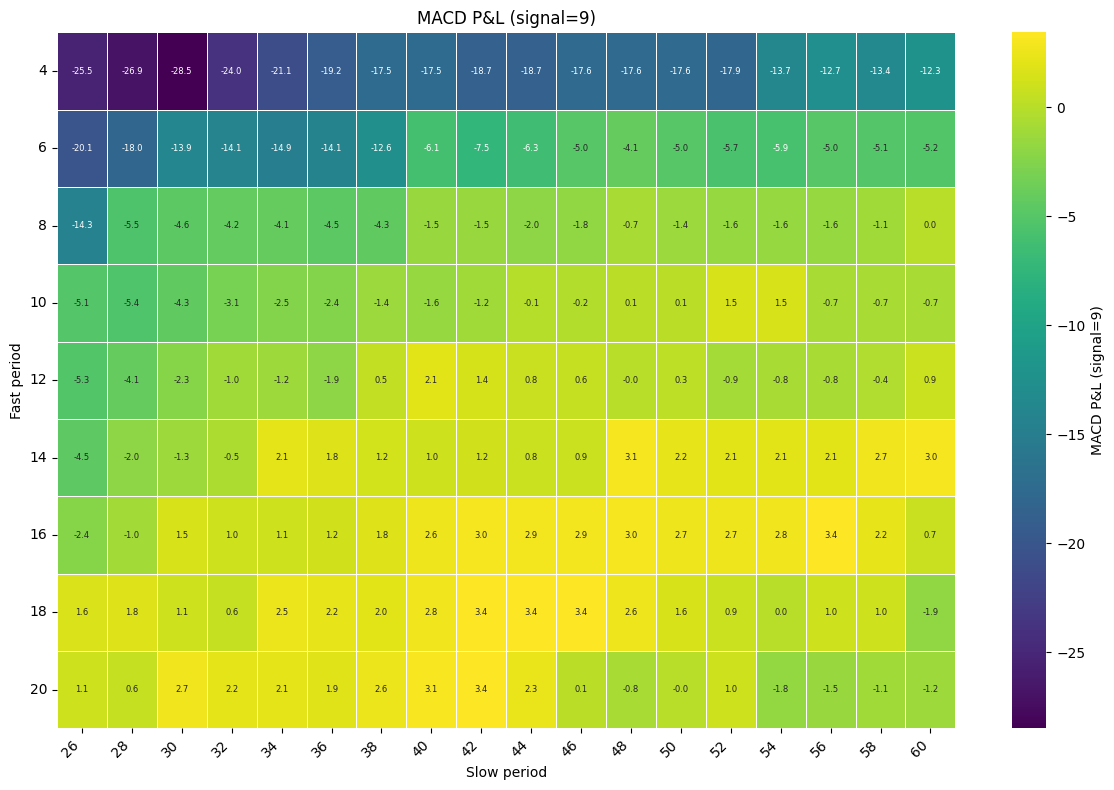

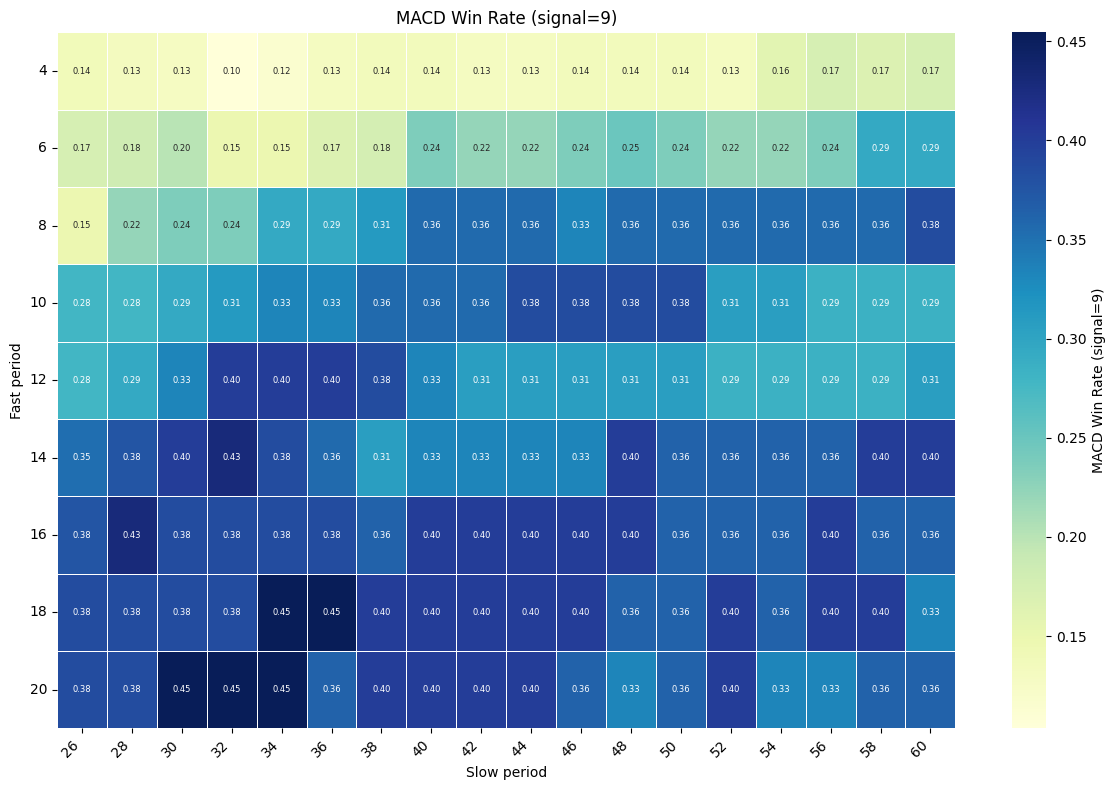

interactive(children=(IntRangeSlider(value=(4, 20), description='Fast EMA:', max=30, min=4, step=2), IntRangeS…

<function __main__.interactive_macd(fast_range, slow_range, signal)>

In [5]:
# ─── Interactive MACD Parameter Sweep ─────────────────────────────────────────
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from backtest_macd import DummyExchange            # ← correct import
from strategies.macd import MacdStrategy
from exchange import fetch_ohlcv
from config import SYMBOL, TIMEFRAME, FEE_PCT, SLIPPAGE_PCT, USDT_AMOUNT

def run_macd_grid(bars, fast, slow, signal, fee_pct, slippage_pct, usdt_amount):
    """
    Run MACD backtest on full OHLCV bars and return list of PnL values.
    """
    dummy = DummyExchange()
    strat = MacdStrategy(dummy, {
        "symbol":       SYMBOL,
        "usdt_amount":  usdt_amount,
        "macd_fast":    fast,
        "macd_slow":    slow,
        "macd_signal":  signal
    })

    pnls = []
    position = None
    entry_cost = entry_price = None

    for i in range(len(bars)):
        window = bars[:i+1]
        sig = strat.on_bar(window)
        price = window[-1][4]

        if sig and sig["side"] == "buy" and position is None:
            slipped    = price * (1 + slippage_pct)
            entry_cost = slipped * (1 + fee_pct)
            entry_price = price
            position    = 'long'

        elif sig and sig["side"] == "sell" and position == 'long':
            slipped  = price * (1 - slippage_pct)
            proceeds = slipped * (1 - fee_pct)
            pnls.append(proceeds - entry_cost)
            position = None

    # close any final open
    if position == 'long':
        price    = bars[-1][4]
        slipped  = price * (1 - slippage_pct)
        proceeds = slipped * (1 - fee_pct)
        pnls.append(proceeds - entry_cost)

    return pnls

def grid_search_macd(fast_list, slow_list, signal, fee_pct, slippage_pct, usdt_amount):
    """
    For a fixed MACD signal period, sweep fast/slow combos.
    Returns a DataFrame with total_pnl and win_rate.
    """
    bars = fetch_ohlcv(SYMBOL, timeframe=TIMEFRAME, limit=500)
    out = []
    for fast in fast_list:
        for slow in slow_list:
            if slow <= fast:
                continue
            pnls     = run_macd_grid(bars, fast, slow, signal, fee_pct, slippage_pct, usdt_amount)
            total    = sum(pnls)
            count    = len(pnls)
            wins     = sum(1 for p in pnls if p > 0)
            win_rate = wins / count if count else 0.0
            out.append({"fast": fast, "slow": slow, "total_pnl": total, "win_rate": win_rate})
    return pd.DataFrame(out)

def plot_heatmap(df, value, cmap, title, fmt):
    heat = df.pivot(index="fast", columns="slow", values=value)

    plt.figure(figsize=(12,8))
    sns.heatmap(
        heat,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        linewidths=0.5,
        linecolor="white",
        annot_kws={"size": 6},
        cbar_kws={"label": title}
    )
    plt.title(title)
    plt.xlabel("Slow period")
    plt.ylabel("Fast period")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def interactive_macd(fast_range, slow_range, signal):
    fast_list = list(range(fast_range[0], fast_range[1]+1, 2))
    slow_list = list(range(slow_range[0], slow_range[1]+1, 2))

    df = grid_search_macd(
        fast_list, slow_list, signal,
        FEE_PCT, SLIPPAGE_PCT, USDT_AMOUNT
    )

    plot_heatmap(df, "total_pnl",  "viridis", f"MACD P&L (signal={signal})", ".1f")
    plot_heatmap(df, "win_rate",  "YlGnBu", f"MACD Win Rate (signal={signal})", ".2f")

# Sliders
fast_slider = widgets.IntRangeSlider(value=[4,20], min=4, max=30, step=2, description="Fast EMA:")
slow_slider = widgets.IntRangeSlider(value=[26,60], min=10, max=80, step=2, description="Slow EMA:")
signal_slider = widgets.IntSlider(value=9, min=4, max=20, step=1, description="Signal EMA:")

display(fast_slider, slow_slider, signal_slider)
widgets.interact(interactive_macd,
                 fast_range=fast_slider,
                 slow_range=slow_slider,
                 signal=signal_slider)
